#빙산 분류 3편(개정판)

# 데이터 불러오기

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/statoil-iceberg-classifier-challenge.zip"

In [ ]:
!pip install py7zr

In [ ]:
import os 
import py7zr
import pandas as pd

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
with py7zr.SevenZipFile("/content/train.json.7z", 'r') as archive:
    archive.extractall(path="/content/train")

with py7zr.SevenZipFile("/content/test.json.7z", 'r') as archive:
    archive.extractall(path="/content/test")

for dirname, _, filenames in os.walk('/content'): 
    for filename in filenames: 
        print(os.path.join(dirname, filename))

In [ ]:
train=pd.read_json("/content/train/data/processed/train.json")
test=pd.read_json("/content/test/data/processed/test.json")

In [ ]:
with py7zr.SevenZipFile("/content/sample_submission.csv.7z", 'r') as archive:
    archive.extractall(path="/content/sample_submission")

for dirname, _, filenames in os.walk('/content'): 
    for filename in filenames: 
        print(os.path.join(dirname, filename))

In [ ]:
sample_submission=pd.read_csv("/content/sample_submission/data/processed/sample_submission.csv")

결측치 채워주기
--

In [ ]:
train.loc[train['inc_angle']=='na']

,id,band_1,band_2,inc_angle,is_iceberg
101,f9209504,"[-13.271194, -12.898959, -14.867657, -16.54327...","[-22.941357, -23.540695, -24.41008, -24.879778...",na,0
126,551856d8,"[-22.102318, -23.761854, -26.414414999999998, ...","[-26.414314, -30.252075, -26.730301, -27.39882...",na,0
142,89842932,"[-13.514271, -11.831821, -13.580964999999999, ...","[-27.900896, -26.317339, -23.394848, -24.97853...",na,0
145,f76458ab,"[-17.553728, -17.245392, -17.553867, -16.85065...","[-25.305712, -24.114067, -25.832432, -25.05414...",na,0
176,9847a428,"[-21.199528, -20.517969, -19.016716, -18.10160...","[-21.024048, -20.852085, -22.962326, -25.46114...",na,0
...,...,...,...,...,...
1599,04e11240,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-27.847719, -28.233864, -24.712077999999998, ...",na,0
1600,c7d6f6f8,"[-25.31155, -26.511555, -28.694487, -27.180115...","[-29.563713, -28.290375, -26.839405, -28.29046...",na,0
1601,bba1a0f1,"[-18.141895, -18.141844, -19.01737, -19.701599...","[-25.305355, -29.387701, -28.963863, -26.16023...",na,0
1602,7f66bb44,"[-22.455633, -25.794661, -26.954567, -22.83354...","[-26.070356, -22.093737, -21.577662, -24.53376...",na,0


In [ ]:
for i in range(0,1604):
    if train.iloc[i, 3]=='na':
        train.iloc[i, 3]=0

In [ ]:
train['inc_angle']=train['inc_angle'].astype('float')

In [ ]:
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

이미지 저장하기
--

In [ ]:
def createIm(data):
    imgs = []

    for i, row in data.iterrows():
    #make 75x75 image
        b_1 = np.array(row['band_1']).reshape(75, 75)
        b_2 = np.array(row['band_2']).reshape(75, 75)
        b_3 = b_1 + b_2

        r = (b_1 + abs(b_1.min())) / np.max((b_1 + abs(b_1.min())))
        g = (b_2 + abs(b_2.min())) / np.max((b_2 + abs(b_2.min())))
        b = (b_3 + abs(b_3.min())) / np.max((b_3 + abs(b_3.min())))

        imgs.append(np.dstack((r, g, b)))
    return np.array(imgs)

In [ ]:
import os,shutil
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
ship=train.loc[train['is_iceberg']==0]
iceberg=train.loc[train['is_iceberg']==1]

배 사진 한 장 보기

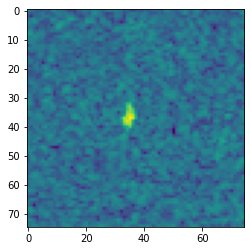

In [ ]:
plt.imshow(np.array(ship.iloc[0, 1]).astype(np.float32).reshape(75,75))
plt.show()

빙산 사진 한 장 보기

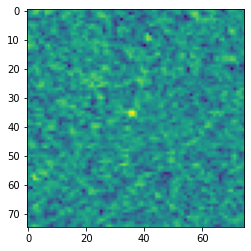

In [ ]:
plt.imshow(np.array(iceberg.iloc[0, 1]).astype(np.float32).reshape(75,75))
plt.show()

이미지 저장할 경로 만들기

In [ ]:
root_dir = '/content/root_dir'
os.mkdir(root_dir) 

학습용 이미지 데이터 저장하기

In [ ]:
train_dir_1 = '/content/root_dir/train_img'
os.mkdir(train_dir_1) 

In [ ]:
train_dir = '/content/root_dir/train_img/train_img'
os.mkdir(train_dir) 

In [ ]:
train_img=createIm(train)
print("학습용 이미지 shape:", train_img.shape)

학습용 이미지 shape: (1604, 75, 75, 3)


In [ ]:
for i,x in enumerate(train_img):
    plt.imsave('/content/root_dir/train_img/train_img/train_%d.jpg'%i,x)

In [ ]:
print('학습 이미지 전체 개수', len(os.listdir(train_dir)))

학습 이미지 전체 개수 1604


학습용 이미지를 학습분리용과 검증용 이미지로 나눠서 저장하기

In [ ]:
from sklearn.model_selection import train_test_split
train_tn, validation=train_test_split(train, test_size=0.2, random_state=42)

In [ ]:
train_tn_dir_1 = '/content/root_dir/train_tn_img'
validation_dir_1 = '/content/root_dir/validation_img'
os.mkdir(train_tn_dir_1)
os.mkdir(validation_dir_1) 

In [ ]:
train_tn_dir = '/content/root_dir/train_tn_img/train_tn_img'
validation_dir = '/content/root_dir/validation_img/validation_img'
os.mkdir(train_tn_dir)
os.mkdir(validation_dir) 

In [ ]:
validation_img=createIm(validation)
train_tn_img=createIm(train_tn)
print("검증용 이미지 shape:", validation_img.shape)

검증용 이미지 shape: (321, 75, 75, 3)


In [ ]:
print("학습분리용 이미지 shape:", train_tn_img.shape)

학습분리용 이미지 shape: (1283, 75, 75, 3)


In [ ]:
for i,x in enumerate(validation_img):
    plt.imsave('/content/root_dir/validation_img/validation_img/validation_%d.jpg'%i,x)

In [ ]:
for i,x in enumerate(train_tn_img):
    plt.imsave('/content/root_dir/train_tn_img/train_tn_img/train_tn_%d.jpg'%i,x)

In [ ]:
print('검증 이미지 전체 개수', len(os.listdir(validation_dir)))
print('학습분리용 이미지 전체 개수', len(os.listdir(train_tn_dir)))

검증 이미지 전체 개수 321
학습분리용 이미지 전체 개수 1283


테스트 이미지 데이터 저장하기

In [ ]:
test_dir_1 = '/content/root_dir/test_img'
os.mkdir(test_dir_1) 

In [ ]:
test_dir = '/content/root_dir/test_img/test_img'
os.mkdir(test_dir) 

In [ ]:
test_img=createIm(test)
print("테스트용 이미지 shape:", test_img.shape)

테스트용 이미지 shape: (8424, 75, 75, 3)


In [ ]:
for i,x in enumerate(test_img):
    plt.imsave('/content/root_dir/test_img/test_img/test_%d.jpg'%i,x)

In [ ]:
print('테스트 이미지 전체 개수', len(os.listdir(test_dir)))

테스트 이미지 전체 개수 8424


배랑 빙산 이미지 훈련과 검증으로 나눠서 저장하기

In [ ]:
ship_train, ship_validation=train_test_split(ship, test_size=0.2, random_state=42)

In [ ]:
print("ship 개수", len(ship.index))
print("ship_train 개수", len(ship_train.index))
print("ship_validation 개수", len(ship_validation.index))

ship 개수 851
ship_train 개수 680
ship_validation 개수 171


In [ ]:
iceberg_train, iceberg_validation=train_test_split(iceberg, test_size=0.2, random_state=42)

In [ ]:
print("iceberg 개수", len(iceberg.index))
print("iceberg_train 개수", len(iceberg_train.index))
print("iceberg_validation 개수", len(iceberg_validation.index))

iceberg 개수 753
iceberg_train 개수 602
iceberg_validation 개수 151


In [ ]:
ship_train_dir_1 = '/content/root_dir/ship_train'
ship_validation_dir_1='/content/root_dir/ship_validation'
iceberg_train_dir_1 = '/content/root_dir/iceberg_train'
iceberg_validation_dir_1='/content/root_dir/iceberg_validation'
os.mkdir(ship_train_dir_1) 
os.mkdir(ship_validation_dir_1)
os.mkdir(iceberg_train_dir_1)
os.mkdir(iceberg_validation_dir_1)

In [ ]:
ship_train_dir = '/content/root_dir/ship_train/ship_train'
ship_validation_dir='/content/root_dir/ship_validation/ship_validation'
iceberg_train_dir = '/content/root_dir/iceberg_train/iceberg_train'
iceberg_validation_dir='/content/root_dir/iceberg_validation/iceberg_validation'
os.mkdir(ship_train_dir) 
os.mkdir(ship_validation_dir)
os.mkdir(iceberg_train_dir)
os.mkdir(iceberg_validation_dir)

In [ ]:
ship_train_img=createIm(ship_train)
ship_validation_img=createIm(ship_validation)

In [ ]:
print("배 학습용 이미지 shape:", ship_train_img.shape)
print("배 검증용 이미지 shape:", ship_validation_img.shape)

배 학습용 이미지 shape: (680, 75, 75, 3)
배 검증용 이미지 shape: (171, 75, 75, 3)


In [ ]:
for i,x in enumerate(ship_train_img):
    plt.imsave('/content/root_dir/ship_train/ship_train/ship_train_%d.jpg'%i,x)

for i,x in enumerate(ship_validation_img):
    plt.imsave('/content/root_dir/ship_validation/ship_validation/ship_validaion_%d.jpg'%i,x)

In [ ]:
iceberg_train_img=createIm(iceberg_train)
iceberg_validation_img=createIm(iceberg_validation)

In [ ]:
print("빙산 학습용 이미지 shape:", iceberg_train_img.shape)
print("빙산 검증용 이미지 shape:", iceberg_validation_img.shape)

빙산 학습용 이미지 shape: (602, 75, 75, 3)
빙산 검증용 이미지 shape: (151, 75, 75, 3)


In [ ]:
for i,x in enumerate(iceberg_train_img):
    plt.imsave('/content/root_dir/iceberg_train/iceberg_train/iceberg_train_%d.jpg'%i,x)

for i,x in enumerate(iceberg_validation_img):
    plt.imsave('/content/root_dir/iceberg_validation/iceberg_validation/iceberg_validaion_%d.jpg'%i,x)

In [ ]:
print("train_dir", len(os.listdir(train_dir)))
print("test_dir", len(os.listdir(test_dir)))
print("train_tn_dir", len(os.listdir(train_tn_dir)))
print("validation_dir", len(os.listdir(validation_dir)))

print("ship_train_dir", len(os.listdir(ship_train_dir)))
print("ship_validation_dir", len(os.listdir(ship_validation_dir)))

print("iceberg_train_dir", len(os.listdir(iceberg_train_dir)))
print("iceberg_validation_dir", len(os.listdir(iceberg_validation_dir)))

train_dir 1604
test_dir 8424
train_tn_dir 1283
validation_dir 321
ship_train_dir 680
ship_validation_dir 171
iceberg_train_dir 602
iceberg_validation_dir 151


# 데이터 전처리

In [ ]:
from torchvision import transforms, datasets
from shutil import copyfile, move
import torchvision
import torch
import torch.nn as nn

In [ ]:
np.array(train['band_1'][0]).shape

(5625,)

In [ ]:
np.sqrt(5625)

75.0

In [ ]:
train_transforms=transforms.Compose([
                                     transforms.Resize((75,75)),
                                     transforms.ToTensor()
])

val_transforms=transforms.Compose([
                                     transforms.Resize((75,75)),
                                     transforms.ToTensor()
])

- transforms.Compose: 불러오는 이미지 데이터에 전처리 및 Augmentation을 다양하게 적용할 때 이용하는 메서드

- transforms.RandomHorizontalFlip: 해당 이미지를 n% 확률로 좌우 반전

- transforms.ToTensor: ToTensor() 형태로 전환 

- transforms.Normalize: ToTensor() 형태로 전환된 이미지에 대해 또 다른 정규화를 진행하는 것을 의미함. 정규화를 진행할 때는 평균과 표준편차가 필요한데, red, green, blue 순으로 평균을 '0.n'씩 적용하는 것을 의미함.  

In [ ]:
train_tn_dir ='/content/root_dir/train_tn_img'
validation_dir ='/content/root_dir/validation_img'

In [ ]:
train_dataset = datasets.ImageFolder(
    train_tn_dir, transform=train_transforms)

val_dataset = datasets.ImageFolder(
    validation_dir, transform=val_transforms)

The files in the image folder need to be placed in the subfolders 

**주의**

반드시, 상위폴더 하에 하위폴더에 사진을 저장해야 DataLoader가 됨.

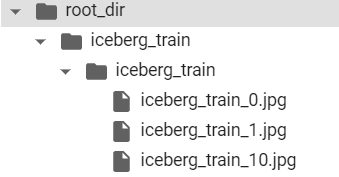

In [ ]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=32,
                                         shuffle=True)
val_loader=torch.utils.data.DataLoader(dataset=val_dataset,
                                       batch_size=32,
                                       shuffle=False)

In [ ]:
if torch.cuda.is_available():
    DEVICE=torch.device('cuda')
else:
    DEVICE=torch.device('cpu')

print('Using Pytorch version:', torch.__version__, 'DEVICE: ', DEVICE)

Using Pytorch version: 1.9.0+cu102 DEVICE:  cpu


In [ ]:
import torch.nn.functional as F

In [ ]:
for (x_train, y_train) in train_loader:
    print('x_train: ', x_train.size(), 'type: ', x_train.type())
    print('y_train: ', y_train.size(), 'type: ', y_train.type())

x_train:  torch.Size([32, 3, 75, 75]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor
x_train:  torch.Size([32, 3, 75, 75]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor
x_train:  torch.Size([32, 3, 75, 75]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor
x_train:  torch.Size([32, 3, 75, 75]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor
x_train:  torch.Size([32, 3, 75, 75]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor
x_train:  torch.Size([32, 3, 75, 75]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor
x_train:  torch.Size([32, 3, 75, 75]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor
x_train:  torch.Size([32, 3, 75, 75]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor
x_train:  torch.Size([32, 3, 75, 75]) type:  torch.FloatTensor
y_train:  torch.Size([32]

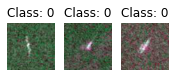

In [ ]:
plt.figure(figsize=(10*1, 1))

for i in range(3):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(x_train[i], (1,2,0)))
    plt.title('Class: '+str(y_train[i].item()))

# Modeling

In [ ]:
from torchsummary import summary

MLP(Multi Layer Perceptron)
--

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # nn.Module 클래스의 매소드를 상속받음
        self.fc1=nn.Linear(75*75, 512)
        # 75*75*1 크기의 노드 수를 설정, 
        # 두 번째 Fully Connected Layer의 노드 수를 512로 설정하기 위해 512로 설정
        self.fc2=nn.Linear(512, 256)
        # 세 번째Fully Connected Layer의 노드 수를 256로 설정하기 위해 256로 설정
        self.fc3=nn.Linear(256,1)
        # Output으로 사용하기 위한 노드 수를 1개로 설정

    def forward(self, x):
        # Forward Propagation 정의 (input -> output 계산과정 나열)
        x=x.view(-1,75*75)
        # view 함수를 통해 1차원 데이터로 변환
        x=self.fc1(x)
        x=F.sigmoid(x)
        x=self.fc2(x)
        x=F.sigmoid(x)
        x=self.fc3(x)
        x=F.sigmoid(x)
        # 이진분류이기 때문에 F.sigmoid
        return x

In [ ]:
model=Net().to(DEVICE)
optimizer=torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion=nn.BCELoss()

print(model)

Net(
  (fc1): Linear(in_features=5625, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
BATCH_SIZE=32
EPOCHS=10

In [ ]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        # train_loader 내에 mini-batch 단위로 저장된 데이터를
        # 순서대로 이용해 학습
        image=image.to(DEVICE)
        label=label.to(DEVICE)
        # image, label을 기존 장비에 할당
        optimizer.zero_grad()
        # Loss의 Gradient 초기화
        output=model(image)
        # input으로 output 계산
        loss=criterion(output, label)
        # F.binary_cross_entropy으로 Loss 값 계싼
        loss.backward()
        # Back Propagation을 통해 계산된 Gradient 값을
        # 각 파라미터에 할당
        optimizer.step()
        # 각 파라미터에 할당된 Gradient 값을 이용해 파라미터 값 업데이터

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)] \t Train Loss: {:.6f}".format(Epoch, 
                batch_idx*len(image), len(train_loader.dataset), 
                100*batch_idx/len(train_loader), loss.item()))

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss=0
    # loss 값을 계산하기 위해 0으로 임시 설정
    correct=0
    # 올바른 Class로 분류한 경우를 세기 위해 0으로 임시 설정

    with torch.no_grad():
        # 모델을 평가하는 과정에서 Gradient를 통해
        # 파라미터 값이 업데이트 되는 현상 방지
        for image, label in test_loader:
            # mini batch 내에 있는 이미지 데이터와
            # 레이블 데이터에 반복문을 이용해 차례로 접근
            image=image.to(DEVICE)
            label=label.to(DEVICE)
            # 이미지와 라벨 기존 장비에 할당
            output=model(image)
            test_loss += criterion(output, label).item()
            # test_loss에 Loss 값을 계산한 결과값을 업데이트
            prediction=output.max(1, keepdim=True)[1]
            # 계산된 벡터 값 내 가장 큰 위치에 대해
            # 해당 위치에 대응하는 클래스로 예측했다고 판단
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            # 예측한 클래스 값과 실제 레이블의 의미하는 클래스가 맞으면
            # correct에 더해 올바르게 예측한 횟수를 저장

    test_loss /= len(test_loader.dataset)
    # 현재까지 계산된 test_loss 값을 test_loader 내에 존재하는
    # mini batch 개수만큼 나눠 평균 loss 값을 계산
    test_accuracy= 100. * correct / len(test_loader.dataset)
    # test_loader 데이터 중 얼마나 맞췄는지를 계산해 정확도를 계산

    return test_loss, test_accuracy

In [ ]:
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy=evaluate(model, test_loader)
    print("\n[EPOCH: {}], \t Test Loss: {:.4f}, \t Test Accuracy: {:.2f}% \n".format(Epoch, test_loss, test_accuracy))

ValueError: ignored

- 오류로 돌아가지 않음

CNN
--

In [ ]:
class CNN(nn.Module):
    # RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (75 x 75). Kernel size can't be greater than actual input size
    # 32 3 75 75   
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,
                             out_channels=32,
                             # depth가 32인 feature map 생성
                             kernel_size=75,
                             padding=1)
        self.conv2=nn.Conv2d(in_channels=32,
                             out_channels=3,
                             kernel_size=75,
                             padding=1)
        # 전의 out_channels와 in_channels 맞춰주기
        self.pool=nn.MaxPool2d(kernel_size=2,
                               stride=2)
        self.fc1=nn.Linear(75*75*3, 64)
        self.fc2=nn.Linear(64,32)
        self.fc3=nn.Linear(32,1)
    
    def forward(self, x):
        x=self.conv1(x)
        x=F.relu(x)
        x=self.pool(x)
        x=self.conv2(x)
        x=F.relu(x)
        x=self.pool(x)

        x=x.view(-1, 32*32*16)
        x=self.fc1(x)
        x=F.relu(x)
        x=self.fc3(x)
        x=F.sigmoid(x)
        return x

In [ ]:
model=CNN().to(DEVICE)
optimizer=torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion=nn.BCELoss()

print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(75, 75), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 3, kernel_size=(75, 75), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16875, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy=evaluate(model, test_loader)
    print("\n[EPOCH: {}], \t Test Loss: {:.4f}, \t Test Accuracy: {:.2f}% \n".format(Epoch, test_loss, test_accuracy))

RuntimeError: ignored

ResNet18
--

In [ ]:
import torchvision.models as models

In [ ]:
model=models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
num_ftrs=model.fc.in_features
model.fc=nn.Linear(num_ftrs, 2)
model=model.to(DEVICE)

In [ ]:
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
critertion=nn.BCELoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model, input_size=(3,75,75))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 38, 38]           9,408
       BatchNorm2d-2           [-1, 64, 38, 38]             128
              ReLU-3           [-1, 64, 38, 38]               0
         MaxPool2d-4           [-1, 64, 19, 19]               0
            Conv2d-5           [-1, 64, 19, 19]          36,864
       BatchNorm2d-6           [-1, 64, 19, 19]             128
              ReLU-7           [-1, 64, 19, 19]               0
            Conv2d-8           [-1, 64, 19, 19]          36,864
       BatchNorm2d-9           [-1, 64, 19, 19]             128
             ReLU-10           [-1, 64, 19, 19]               0
       BasicBlock-11           [-1, 64, 19, 19]               0
           Conv2d-12           [-1, 64, 19, 19]          36,864
      BatchNorm2d-13           [-1, 64, 19, 19]             128
             ReLU-14           [-1, 64,

In [ ]:
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy=evaluate(model, test_loader)
    print("\n[EPOCH: {}], \t Test Loss: {:.4f}, \t Test Accuracy: {:.2f}% \n".format(Epoch, test_loss, test_accuracy))

ValueError: ignored

ResNet34
--

In [ ]:
import torchvision.models as models

In [ ]:
model=models.resnet34(pretrained=False)
num_ftrs=model.fc.in_features
model.fc=nn.Linear(num_ftrs, 2)
model=model.to(DEVICE)

In [ ]:
optimizer=torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy=evaluate(model, test_loader)
    print("\n[EPOCH: {}], \t Test Loss: {:.4f}, \t Test Accuracy: {:.2f}% \n".format(Epoch, test_loss, test_accuracy))

ValueError: ignored

Resnet_50
--

In [ ]:
model = torchvision.models.resnet50(pretrained=True).to(DEVICE)
num_ftrs=model.fc.in_features
model.fc=nn.Linear(num_ftrs, 1)

In [ ]:
num_ftrs=model.fc.in_features
model.fc=nn.Linear(num_ftrs, 1)

In [ ]:
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
summary(model, input_size=(3,75,75))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 38, 38]           9,408
       BatchNorm2d-2           [-1, 64, 38, 38]             128
              ReLU-3           [-1, 64, 38, 38]               0
         MaxPool2d-4           [-1, 64, 19, 19]               0
            Conv2d-5           [-1, 64, 19, 19]           4,096
       BatchNorm2d-6           [-1, 64, 19, 19]             128
              ReLU-7           [-1, 64, 19, 19]               0
            Conv2d-8           [-1, 64, 19, 19]          36,864
       BatchNorm2d-9           [-1, 64, 19, 19]             128
             ReLU-10           [-1, 64, 19, 19]               0
           Conv2d-11          [-1, 256, 19, 19]          16,384
      BatchNorm2d-12          [-1, 256, 19, 19]             512
           Conv2d-13          [-1, 256, 19, 19]          16,384
      BatchNorm2d-14          [-1, 256,

Fasterrcnn_resnet50_fpn
--

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
def get_model_instance_segmentation(num_classes):
  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
model=get_model_instance_segmentation(1)

In [ ]:
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
EPOCHS=10

for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy=evaluate(model, test_loader)
    print('\n[EPOCH: {}], \t Test Loss: {:.4f}, \t Test Accuracy: {.2f}% \n'.format(Epoch, test_loss, test_accuracy))